# Microtubule Dataset

- We use [`anamic`](https://github.com/hadim/anamic) to simulate microscopy images of microtubule.
- In short, each dimer positions is computed in 3D then projected on a 2D plan. Dimers are then convoled with a PSF and some noise is added.

In [ ]:
%%bash
pip install --upgrade https://github.com/hadim/anamic/archive/c2c304763fd7835cc0bb5efa246cd5b3c4ed0891.zip

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split
import tqdm
from PIL import Image
from skimage import exposure
from joblib import Parallel, delayed

import sys; sys.path.append("../../../")
import maskflow

import anamic

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/Microtubule")

data_dir = root_dir / "Data Small"
data_dir.mkdir(parents=True, exist_ok=True)

config = maskflow.config.load_config("config.yaml")

# Copy config next to data folder
maskflow.config.save_config(config, root_dir / "config.yaml")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Build microtubule images

In [7]:
# Common Parameters
pixel_size = 110  # nm/pixel
image_size_pixel = 128
n_images = 20

# Per image parameters
image_parameters = {}
image_parameters['n_mt'] = {}
image_parameters['n_mt']['values'] = np.arange(2, 3)
#image_parameters['n_mt']['values'] = np.arange(2, 3)
image_parameters['n_mt']['prob'] = 'uniform'

image_parameters['signal_mean'] = {}
image_parameters['signal_mean']['values'] = {'loc': 700, 'scale': 20}
image_parameters['signal_mean']['prob'] = 'normal'

image_parameters['signal_std'] = {}
image_parameters['signal_std']['values'] = {'loc': 100, 'scale': 5}
image_parameters['signal_std']['prob'] = 'normal'

image_parameters['bg_mean'] = {}
image_parameters['bg_mean']['values'] = {'loc': 500, 'scale': 30}
image_parameters['bg_mean']['prob'] = 'normal'

image_parameters['bg_std'] = {}
image_parameters['bg_std']['values'] = {'loc': 24, 'scale': 5}
image_parameters['bg_std']['prob'] = 'normal'

image_parameters['noise_factor'] = {}
image_parameters['noise_factor']['values'] = np.arange(0.8, 2.0, 0.1)
image_parameters['noise_factor']['prob'] = 'uniform'

# Per microtubule parameters
microtubule_parameters = {}

microtubule_parameters['n_pf'] = {}
microtubule_parameters['n_pf']['values'] = [11, 12, 13, 14, 15]
microtubule_parameters['n_pf']['prob'] = [0.05, 0.05, 0.3, 0.1, 0.5]

microtubule_parameters['mt_length_nm'] = {}
microtubule_parameters['mt_length_nm']['values'] = np.arange(2000, 3000)
microtubule_parameters['mt_length_nm']['prob'] = 'uniform'

microtubule_parameters['taper_length_nm'] = {}
microtubule_parameters['taper_length_nm']['values'] = np.arange(0, 3000)
microtubule_parameters['taper_length_nm']['prob'] = 'uniform'

microtubule_parameters['labeling_ratio'] = {}
microtubule_parameters['labeling_ratio']['values'] = [0.08, 0.09, 0.10, 0.11, 0.12, 0.13]
microtubule_parameters['labeling_ratio']['prob'] = 'uniform'

microtubule_parameters['pixel_size'] = pixel_size
microtubule_parameters['x_offset'] = 2000  # nm
microtubule_parameters['y_offset'] = 2000  # nm
microtubule_parameters['psf_size'] = 135  # nm

In [8]:
assert config['INPUT']['MAX_SIZE_TRAIN'] == image_size_pixel

training_size = 0.8  # From 0 to 1
png_compression_level = 0  # From 0 to 9

len_dataset = n_images

train_ids, _ = train_test_split(np.arange(0, len_dataset), train_size=training_size)

train_dir = data_dir / "train_dataset"
train_dir.mkdir(parents=True, exist_ok=True)

test_dir = data_dir / "test_dataset"
test_dir.mkdir(parents=True, exist_ok=True)

train_annotations_path = data_dir / "train_annotations.json"
test_annotations_path = data_dir / "test_annotations.json"

train_annotations = maskflow.dataset.get_base_annotations(['microtubule'], supercategory="cytoskeleton")
test_annotations = maskflow.dataset.get_base_annotations(['microtubule'], supercategory="cytoskeleton")

worker_args = []
for i in range(n_images):
    worker_args.append({'i': i, 'image_size_pixel': image_size_pixel, 'pixel_size': pixel_size,
                        'microtubule_parameters': microtubule_parameters,
                        'image_parameters': image_parameters.copy(),
                        'png_compression_level': png_compression_level})
        
        
def worker(i, image_size_pixel, pixel_size, microtubule_parameters, image_parameters, png_compression_level):
    
    image, masks = anamic.fov.create_fov(image_size_pixel, pixel_size, microtubule_parameters, image_parameters)
    assert image.shape[-2:] == (image_size_pixel, image_size_pixel)
    
    # Get the annotation in the COCO format.
    basename = f"microtubules_{i:05d}.png"

    # Only keep masks with more than 5 pixels
    mask_to_keep = masks.sum(axis=-1).sum(axis=-1) > 5
    masks = masks[mask_to_keep]
    
    if masks.shape[0] == 0:
        return None
    
    class_ids = np.ones(masks.shape[0])
    
    image = exposure.rescale_intensity(image, out_range='uint8')
    image = image.astype('uint8')

    image_info, image_annotations = maskflow.dataset.get_annotations(i, basename, image, masks, class_ids)
    
    if i in train_ids:
        image_path = train_dir / basename
        is_train = True
    else:
        image_path = test_dir / basename
        is_train = False
        
    Image.fromarray(image, mode='L').save(str(image_path), compress_level=png_compression_level)
    return is_train, image_info, image_annotations

executor_factory = anamic.utils.parallel_executor(use_bar='tqdm', n_jobs=-1)(total=len(worker_args))
executors = [executor_factory(delayed(worker)(**worker_arg) for worker_arg in worker_args)]

for executor in executors:
    for results in executor:
        if results:
            is_train, image_info, image_annotations = results
            if is_train:
                train_annotations['images'].append(image_info)
                train_annotations['annotations'].extend(image_annotations)
            else:
                test_annotations['images'].append(image_info)
                test_annotations['annotations'].extend(image_annotations)
    
maskflow.dataset.save_annotations(train_annotations, train_annotations_path)
maskflow.dataset.save_annotations(test_annotations, test_annotations_path)

## Check the dataset

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


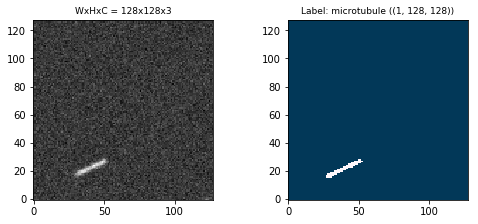

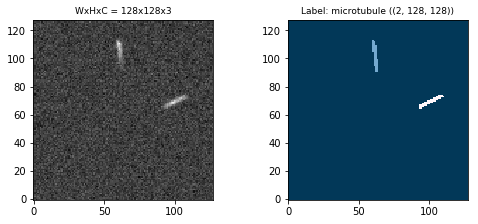

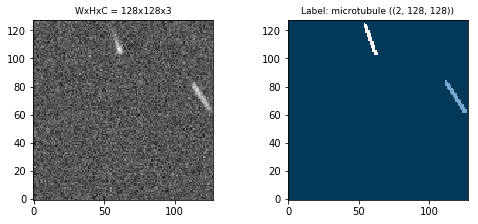

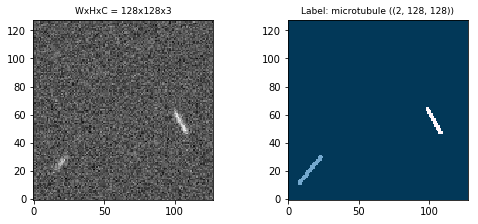

In [11]:
config['SOLVER']['IMS_PER_BATCH'] = 1
config['TEST']['IMS_PER_BATCH'] = 1

# Number of batch to load
n = 4

# Load some data
data_loader = maskflow.dataset.get_data_loader(config, data_dir, is_train=True)
some_data = [iter(data_loader).next() for _ in range(n)]

# Retrieve category's names
categories = data_loader.dataset.coco.cats

for batch_image, batch_target, batch_idx in some_data:
    maskflow.viz.batch_display_top_masks(batch_image, batch_target, batch_idx, categories,
                                         basesize=7, limit=1, cmap="PuBu_r",
                                         pixel_mean=config['INPUT']['PIXEL_MEAN'],
                                         pixel_std=config['INPUT']['PIXEL_STD'])